In [ ]:
# !pip install tensorflow_probability
# !pip install keras

In [64]:
import imageio
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import math

import time

In [65]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()


def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(
    test_images).shuffle(test_size).batch(batch_size))

In [66]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    32, 3, strides=(1, 1), activation='relu'),
                tf.keras.layers.Conv2D(
                    64, 3, strides=(1, 1), activation='relu'),
                tf.keras.layers.Conv2D(
                    128, 3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    256, 3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim)
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape((7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    256, 3, strides=1, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    128, 3, strides=1, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    64, 3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    32, 3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    1, 3, strides=1, padding='same')
            ]
        )

    def sample(self, randinp=None):
        # if randinp is None:
        #     randinp = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(randinp, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [67]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


gradients = tf.Variable(0)
loss= tf.Variable(0)
tape = tf.Variable(0)
class Trainer(object):
	def __init__(self, model, optimizer):
		self.model = model
		self.optimizer = optimizer

	@tf.function
	def train_step(self,x):
		with tf.GradientTape() as tape:
			loss = compute_loss(self.model, x)
		gradients = tape.gradient(loss, self.model.trainable_variables)
		self.optimizer.apply_gradients(
			zip(gradients, self.model.trainable_variables))
		return gradients


In [68]:
print(tf.config.list_physical_devices('GPU'))
# random_vector_for_generation = tf.random.normal(
#     shape=[5, 16])
# model = VAE(16)
# # trainer = Trainer(model, optimizer)
# p = model.encode(train_images[0:10])
# print(p[0].shape, p[1].shape)
# predictions = model.sample(random_vector_for_generation)
# for i in range(predictions.shape[0]):
# 	plt.subplot(1, 5, i + 1)
# 	plt.imshow(predictions[i, :, :, 0], cmap='gray')
# 	plt.axis('off')

[]


In [69]:
epochs = 10
num_examples_to_generate = 5

In [70]:
def generate_and_save_images(model, epoch, latent_dim):
	predictions = model.sample(random_vector_for_generation)
	fig = plt.figure(figsize=(4, 4))

	for i in range(predictions.shape[0]):
		plt.subplot(1, 5, i + 1 )
		plt.imshow(predictions[i, :, :, 0], cmap='gray')
		plt.axis('off')

	# tight_layout minimizes the overlap between 2 sub-plots
	plt.savefig('image_at_epoch_{:04d}_dim{:02d}.png'.format(epoch,latent_dim))
	plt.show()

In [71]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [74]:
def make_gif(latent_dim):
	anim_file = 'vae{:d}.gif'.format(latent_dim)
	with imageio.get_writer(anim_file, mode='I') as writer:
		filenames = ['image_at_epoch_{:04d}_dim{:02d}.png'.format(i,latent_dim) for i in range(0, epochs+1)]
		# filenames = sorted(filenames)
		for filename in filenames:
			image = imageio.imread(filename)
			writer.append_data(image)
		image = imageio.imread(filename)
		writer.append_data(image)

Epoch: 3, Test set ELBO: -155.15269470214844, time elapse for current epoch: 102.57766151428223,dim:2


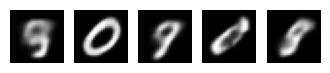

KeyboardInterrupt: 

In [75]:
with tf.device('/GPU:0'):
	for latent_dim in [2,4,8,16,32,64]:
		random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
		model = VAE(latent_dim)
		optimizer = tf.keras.optimizers.Adam(1e-4)
		optimizer.build(model.trainable_variables)
		train=Trainer(model, optimizer)
		generate_and_save_images(model, 0, latent_dim)
		for epoch in range(1, epochs + 1):
			start_time = time.time()
			for train_x in train_dataset:
				train.train_step(train_x)
			end_time = time.time()

			loss = tf.keras.metrics.Mean()
			for test_x in test_dataset:
				loss(compute_loss(model, test_x))
			elbo = -loss.result()
			display.clear_output(wait=False)
			print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {},dim:{}'
					.format(epoch, elbo, end_time - start_time,latent_dim))
			generate_and_save_images(model, epoch, latent_dim)
		make_gif(latent_dim)